In [14]:
import platform
import psutil

cpu_info = platform.processor()
cpu_usage = psutil.cpu_percent()

print("CPU Information:")
print("CPU: ", cpu_info)
print("CPU Usage: ", cpu_usage)


CPU Information:
CPU:  arm
CPU Usage:  13.7


In [15]:
import multiprocessing

available_cpu_cores = multiprocessing.cpu_count()

print("Available CPU Cores: ", available_cpu_cores)


Available CPU Cores:  8


In [16]:
import psutil

ram = psutil.virtual_memory()

print("RAM Information:")
print("Total RAM: ", ram.total)
print("Available RAM: ", ram.available)
print("Used RAM: ", ram.used)
print("RAM Usage Percentage: ", ram.percent)



RAM Information:
Total RAM:  8589934592
Available RAM:  3759144960
Used RAM:  3966140416
RAM Usage Percentage:  56.2


In [17]:
import psutil

ram = psutil.virtual_memory()

total_ram_gb = round(ram.total / (1024**3), 2)
available_ram_gb = round(ram.available / (1024**3), 2)
used_ram_gb = round(ram.used / (1024**3), 2)

print("RAM Information:")
print("Total RAM: ", total_ram_gb, "GB")
print("Available RAM: ", available_ram_gb, "GB")
print("Used RAM: ", used_ram_gb, "GB")
print("RAM Usage Percentage: ", ram.percent, "%")

RAM Information:
Total RAM:  8.0 GB
Available RAM:  3.46 GB
Used RAM:  3.69 GB
RAM Usage Percentage:  56.8 %


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random
from tqdm import tqdm
import time
import copy

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

torch.backends.cudnn.benchmark=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.manual_seed(5703)
torch.manual_seed(5703)
np.random.seed(5703)
random.seed(5703)




In [6]:
d1 = pd.read_csv('/Users/belsabel/Downloads/Device #1.csv')
d4 = pd.read_csv('/Users/belsabel/Downloads/Device #4.csv')
d5 = pd.read_csv('/Users/belsabel/Downloads/Device #5.csv')
d6 = pd.read_csv('/Users/belsabel/Downloads/Device #6.csv')  
d7 = pd.read_csv('/Users/belsabel/Downloads/Device #7.csv') 


In [21]:
d1.shape, d4.shape, d5.shape, d6.shape, d7.shape


((1018298, 117), (1098677, 117), (941346, 117), (836891, 117), (835876, 117))

In [22]:
def pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'] 
    benign = benign.drop('type',1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign']
    abnormal = abnormal.drop('type',1)
    abnormal['type'] = 1
  

    # split benign data evenly to three parts
    benign_train, benign_tr, benign_test = np.split(benign, [int((1/3)*len(benign)), int((2/3)*len(benign))])
    benign_test_mix = benign_test.copy()    # with label 116

    train_label = benign_train['type']

    benign_train = benign_train.drop('type',axis=1)
    benign_tr = benign_tr.drop('type',axis=1)

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)              # use all abnormal data.  (frac = 0.1) -> select 10%
    mix_temp = pd.concat([benign_test_mix, abnormal_sample]) # concatenate
    mix_temp = shuffle(mix_temp, random_state=1)  

    mix = mix_temp.copy()                   # mix with label # 116
    mix_data = mix_temp.drop('type',axis=1) # only data      # 115
    mix_label = mix['type']

    scaler = StandardScaler()
    benign_train = scaler.fit_transform(benign_train) # 115 all benign 
    benign_tr = scaler.transform(benign_tr)           # 115 all benign 
    mix_data = scaler.transform(mix_data)             # ([xxx, 115])

    # keep benign_train as original form here --> for later use
    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)    # 115  all benign --> for calculate threshold
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)      # 115  benign + abnormal  --> for evaluation
    mix_label = torch.tensor(np.array(mix_label))

    return benign_train, benign_tr, mix_data, mix_label



In [23]:
def other_pre_processing(data):
    data = data.drop(data.columns[0], axis=1)

    benign = data[data['type'] == 'benign'] 
    benign = benign.drop('type',1)
    benign['type'] = 0

    abnormal = data[data['type'] != 'benign']
    abnormal = abnormal.drop('type',1)
    abnormal['type'] = 1
    

    # split benign data to two parts
    benign_tr, benign_test = train_test_split(benign, test_size = 0.2, random_state = 5703)
    benign_tr = benign_tr.drop('type',axis=1)

    # Create Mix data
    abnormal_sample = abnormal.sample(frac = 1)           # 116  use all abnoraml, but can change to use part
    mix_temp = pd.concat([benign_test, abnormal_sample])  # 116
    mix_temp = shuffle(mix_temp, random_state=1)          # for test model

    mix = mix_temp.copy()                   # mix data with label # 116
    mix_data = mix_temp.drop('type',axis=1) # no label # 115
    mix_label = mix['type']

    # Standardisation
    scaler = StandardScaler()
    benign_tr = scaler.fit_transform(benign_tr)        
    mix_data = scaler.transform(mix_data) 

    benign_tr = torch.from_numpy(np.array(benign_tr)).float().to(device)  # 115  all benign --> for calculate threshold
    mix_data = torch.from_numpy(np.array(mix_data)).float().to(device)    # 115  data -> benign + abnormal  --> for evaluation
    mix_label = torch.tensor(np.array(mix_label))                         # 0/1  label -> benign + abnormal  --> for evaluation

    return benign_tr, mix_data, mix_label




In [24]:
import time



# for Federated Model training
benign_train_1, benign_tr_1, mix_data_1, mix_label_1 = pre_processing(d1)

benign_train_4, benign_tr_4, mix_data_4, mix_label_4 = pre_processing(d4)

benign_train_5, benign_tr_5, mix_data_5, mix_label_5 = pre_processing(d5)

benign_train_6, benign_tr_6, mix_data_6, mix_label_6 = pre_processing(d6)

benign_train_7, benign_tr_7, mix_data_7, mix_label_7 = pre_processing(d7)








/var/folders/r4/36q27nxn72x2s9cm2mkghvhm0000gn/T/ipykernel_70800/3348569716.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  benign = benign.drop('type',1)
/var/folders/r4/36q27nxn72x2s9cm2mkghvhm0000gn/T/ipykernel_70800/3348569716.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  abnormal = abnormal.drop('type',1)
/var/folders/r4/36q27nxn72x2s9cm2mkghvhm0000gn/T/ipykernel_70800/3348569716.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  benign = benign.drop('type',1)
/var/folders/r4/36q27nxn72x2s9cm2mkghvhm0000gn/T/ipykernel_70800/3348569716.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  abnormal = abnormal.drop('type',1)
/var

In [25]:
num_clients = 5    # Number of clients
num_selected = 2    # Typically, num_selected is around 30–40% of the num_clients.
batch_size = 128
baseline_num = 1000  # choose some data from the train set to retrain the data from trained model 
num_rounds = 3#100      # Total number of communication rounds for the global model to train.
epochs = 5           # for train client model
retrain_epochs = 5  # Total number of retraining rounds on the global server after receiving the model weights 
                      # from all the clients that participated in the communication round.
    
    

In [26]:
# For retraining mechanism
# pick baseline_data for each device
def baseline_data(size = baseline_num, batch_size = batch_size): # baseline_num
    rng = np.random.default_rng()
    
    x_1 = rng.choice(benign_train_1, size=size, replace = True, shuffle = True, axis=0) # [[[[[[randomly select]]]]]] 
    x_4 = rng.choice(benign_train_4, size=size, replace = True, shuffle = True, axis=0)
    x_5 = rng.choice(benign_train_5, size=size, replace = True, shuffle = True, axis=0)
    x_6 = rng.choice(benign_train_6, size=size, replace = True, shuffle = True, axis=0)
    x_7 = rng.choice(benign_train_7, size=size, replace = True, shuffle = True, axis=0)


    loader_1 = torch.utils.data.DataLoader(x_1, batch_size=batch_size)
    loader_4 = torch.utils.data.DataLoader(x_4, batch_size=batch_size)
    loader_5 = torch.utils.data.DataLoader(x_5, batch_size=batch_size)
    loader_6 = torch.utils.data.DataLoader(x_6, batch_size=batch_size)
    loader_7 = torch.utils.data.DataLoader(x_7, batch_size=batch_size)

    loaders = {'D1': loader_1,
               'D4': loader_4,
               'D5': loader_5,
               'D6': loader_6,
               'D7': loader_7}

    return loaders
     

In [27]:

# FedAvgM
def server_aggregate_M(global_model, client_models, client_lens):
    total = sum(client_lens)    # 592    sum [51, 122, 162, 257]
    n = len(client_models)      # 4 local clients
    global_dict = global_model.state_dict() # weight/bias dict --> {'encoder.0.weight': Tensor with shape torch.Size([86, 115]), 'encoder.0.bias':....} 16 items
    temp = copy.deepcopy(global_dict)       # temporary weight/bias dict
    v = {x:1 for x in copy.deepcopy(global_dict)}   # initialise v

    for i,k in enumerate(global_dict.keys()): 
        # calculate average weight/bias --> avg_w/b
        temp[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
        temp_v = 0.9 * v[k] + temp[k]               # v = 0.9v + avg_w/b   momentum=0.9
        global_dict[k] = global_dict[k] - temp_v    # w = w - v
    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict()) # local model get updated weight/bias

In [28]:
# for main training process
# collect training data of each device
def train_data_loaders(batch_size = batch_size):
    
    data_1 = torch.utils.data.DataLoader(benign_train_1, batch_size = batch_size, shuffle=True)
    data_4 = torch.utils.data.DataLoader(benign_train_4, batch_size = batch_size, shuffle=True)
    data_5 = torch.utils.data.DataLoader(benign_train_5, batch_size = batch_size, shuffle=True)
    data_6 = torch.utils.data.DataLoader(benign_train_6, batch_size = batch_size, shuffle=True)
    data_7 = torch.utils.data.DataLoader(benign_train_7, batch_size = batch_size, shuffle=True)
    
    client_loaders = {'D1': data_1,
                      'D4': data_4,
                      'D5': data_5, 
                      'D6': data_6,
                      'D7': data_7}
               

    return client_loaders


In [29]:
def client_update(client_model, optimizer, train_data, epoch=3):
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        start_time = time.time() # start timing
        for bx, (data) in enumerate(train_data):
            output = client_model(data.float()) # tensor 115
            optimizer.zero_grad()
            loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss/len(train_data)
        end_time = time.time() # end timing
        epoch_time = end_time - start_time # calculate epoch training time
        print(f"Device training time for epoch {e+1}: {epoch_time:.2f} seconds") # print epoch training time
    return epoch_loss



In [30]:
# for updates/trains client model on client data
# local training round that takes place for every selected client

def client_update(client_model, optimizer, train_data, epoch=3):
    model.train()
    for e in range(epoch):
        running_loss = 0.0
        for bx, (data) in enumerate(train_data):
            output = client_model(data.float()) # tensor 115
            optimizer.zero_grad()
            loss = nn.MSELoss(reduction='mean')(data.float().to(device), output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss/len(train_data)
    return epoch_loss
   



# synchronizes the client model with global weights (before training)
def client_syn(client_model, global_model):
    client_model.load_state_dict(global_model.state_dict())
    

In [31]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# Deep Auto-encoder model
input_dim = 115
class AEModel(nn.Module):
    def __init__(self):
        super(AEModel,self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.25*input_dim)),
            nn.Tanh(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(int(0.25*input_dim), int(0.33*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.33*input_dim), int(0.5*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.5*input_dim), int(0.75*input_dim)),
            nn.Tanh(),
            nn.Linear(int(0.75*input_dim), int(input_dim)),
            nn.Tanh(),
        )
    def forward(self, x):
        encode = self.encoder(x)
        decoder = self.decoder(encode)
        return decoder                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
        

In [32]:
# Initializing models and optimizer

global_model = AEModel().to(device)
client_models = [AEModel().to(device) for _ in range(num_selected)] # part or all clients

for model in client_models:
    model.load_state_dict(global_model.state_dict())

opt = [torch.optim.SGD(model.parameters(), lr = 0.012, weight_decay=1e-05, momentum=0.9) for model in client_models]


In [33]:

baseline_data = baseline_data() # size = 1000
train_loader = train_data_loaders() #batch_size=128
devices = ['D1','D4','D5','D6','D7']



In [34]:
# Train Client Model and Global Model
train_loss_client = []
train_loss_global = []

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] 
    # client_lens = [len(train_loader[idx]) for idx in client_idx ]
    # print(client_lens)


    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)): 
        # print(i)
        client_syn(client_models[i], global_model)
        loss += client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
    train_loss_client.append(loss)


    #### retraining on the global server ####
    loss_retrain = 0
    for i in tqdm(range(num_selected)): 
        loss_retrain += client_update(client_models[i], opt[i], baseline_data[devices[client_idx[i]]], retrain_epochs)
    train_loss_global.append(loss_retrain/num_selected)


    ### aggregate models ###
    # server_aggregate(global_model, client_models, client_lens)      # FedAvg
    server_aggregate_M(global_model, client_models, client_lens)    # FedAvgM

    print("\nclient_loss: ", loss)
    print('global_loss: ', loss_retrain/num_selected)

# save model
torch.save(global_model,'global.pt')

time_required = time.time() - start_time
print('\nTIME: {}mins'.format(time_required/60))



round:  1
client_idx:  [1 0]


100%|██████████| 2/2 [00:00<00:00, 21.46it/s]



client_loss:  1.552568998425933
global_loss:  0.591718889772892

round:  2
client_idx:  [4 3]


100%|██████████| 2/2 [00:00<00:00, 24.67it/s]



client_loss:  2.342369684177746
global_loss:  1.1908578537404537

round:  3
client_idx:  [2 3]


100%|██████████| 2/2 [00:00<00:00, 24.35it/s]


client_loss:  2.595798549869287
global_loss:  1.356698963791132

TIME: 0.15290391445159912mins


In [35]:
train_loss_client = []
train_loss_global = []
client_train_times = []  # List to store training times for each client
num_clients= 5

start_time = time.time()

for r in range(num_rounds): # total number of rounds

    print('\nround: ', r+1)
    # num_selected = random.choice(range(1,num_clients))
    client_idx = np.random.permutation(num_clients)[:num_selected] # random pick some clients from all clients for train
    print('client_idx: ',client_idx)
    client_lens = [len(train_loader[devices[idx]]) for idx in client_idx ] 

    #### client update ####
    loss = 0
    for i in tqdm(range(num_selected)):
        start_client_time = time.time()  # Record start time
        client_syn(client_models[i], global_model)
        loss += client_update(client_models[i], opt[i], train_loader[devices[client_idx[i]]], epochs)
        end_client_time = time.time()  # Record end time
        client_train_times.append(end_client_time - start_client_time)  # Append training time to list
    train_loss_client.append(loss)

    # Rest of the code...

# Print training times for each client
for i in range(num_clients):
    print(f"Client {i+1} training time: {sum(client_train_times[i::num_clients]) / num_rounds} seconds")



round:  1
client_idx:  [2 4]


100%|██████████| 2/2 [00:02<00:00,  1.40s/it]



round:  2
client_idx:  [0 2]


100%|██████████| 2/2 [00:03<00:00,  1.55s/it]



round:  3
client_idx:  [1 0]


100%|██████████| 2/2 [00:03<00:00,  1.57s/it]

Client 1 training time: 1.1065723101298015 seconds
Client 2 training time: 0.05763467152913412 seconds
Client 3 training time: 0.22293909390767416 seconds
Client 4 training time: 0.8076002597808838 seconds
Client 5 training time: 0.8093990484873453 seconds


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

def get_tr(model, tr_data):
    model.eval()
    mse = np.mean(np.power(tr_data.cpu().detach().numpy() - model(tr_data).cpu().detach().numpy(), 2), axis=1)
    tr = mse.mean() + mse.std()
    return tr

def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_pred)): 
        if y_actual[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_actual[i]!=y_pred[i]:
           FP += 1
        if y_actual[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_actual[i]!=y_pred[i]:
           FN += 1
    return (TP, FP, TN, FN)

def get_mix_result(model, tr, mix_data, mix_label):
    model.eval()
    mse = np.mean(np.power(mix_data.cpu().detach().numpy() - model(mix_data).cpu().detach().numpy(), 2), axis=1)

    prediction = []
    for i in mse:
        if i > tr:
            prediction.append(1)
        else:
            prediction.append(0)
    
    mix_label_list = mix_label.tolist()
    TP,FP,TN,FN = perf_measure(mix_label_list, prediction)
    conf = [[TP, FN],[FP, TN]]
    x_axis_label = ['abnormal', 'benign']
    y_axis_label = ['abnormal', 'benign']
    plt.figure()
    sns.heatmap(conf,xticklabels=x_axis_label, yticklabels=y_axis_label, annot=True,annot_kws={"size": 16},fmt='g')
    acc = (TP+TN) / (TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1score = 2 * ((precision * recall) / (precision + recall))

    TPR = round((TP / (TP+FN)), 6) 
    # print('TPR is: {}%'.format(TPR))

    FPR = round((FP / (FP + TN)), 6)
    # print('TPR is: {}%'.format(FPR))

    print('Acc: %.3f%% \nPrecision: %.3f \nRecall: %.3f \nF1score: %.3f \nTPR: %.5f \nFPR: %.5f'%(acc*100, 
                                                                                                   precision, 
                                                                                                   recall, 
                                                                                                   F1score*100, 
                                                                                                   TPR, 
                                                                                                   FPR))
    
    # add ROC curve
    fpr, tpr, _ = roc_curve(mix_label_list, prediction)
    roc_auc = auc(fpr, tpr)
    print("roc",roc_auc)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title


In [39]:

# load model
global_model = torch.load('global.pt')


In [40]:
# Calculate TR
tr_1 = get_tr(global_model, benign_tr_1)
tr_4 = get_tr(global_model, benign_tr_4)
tr_6 = get_tr(global_model, benign_tr_6)
tr_5 = get_tr(global_model, benign_tr_5)
tr_7 = get_tr(global_model, benign_tr_7)


D1: 
Acc: 99.987% 
Precision: 1.000 
Recall: 1.000 
F1score: 99.993 
TPR: 0.99998 
FPR: 0.00702
roc 0.9964799957499667

D4: 
Acc: 99.851% 
Precision: 0.999 
Recall: 1.000 
F1score: 99.921 
TPR: 0.99986 
FPR: 0.02282
roc 0.9885202162721918

D5: 
Acc: 99.823% 
Precision: 0.998 
Recall: 1.000 
F1score: 99.905 
TPR: 0.99984 
FPR: 0.02282
roc 0.9885078299745846

D6: 
Acc: 99.870% 
Precision: 0.999 
Recall: 1.000 
F1score: 99.932 
TPR: 0.99989 
FPR: 0.02805
roc 0.9859224395928415

D7: 
Acc: 99.978% 
Precision: 1.000 
Recall: 1.000 
F1score: 99.989 
TPR: 1.00000 
FPR: 0.04118
roc 0.9794097460535346


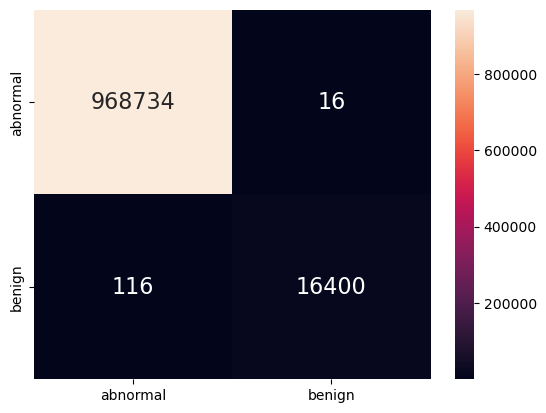

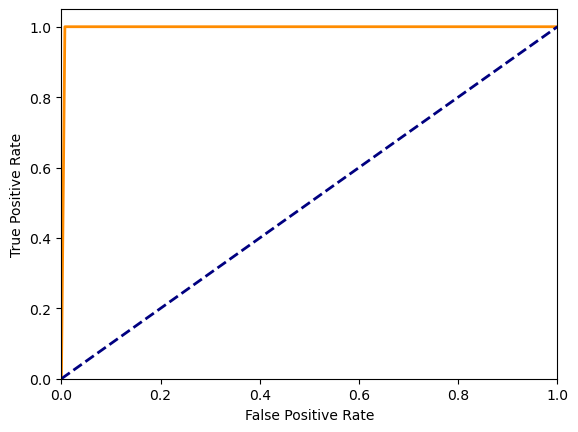

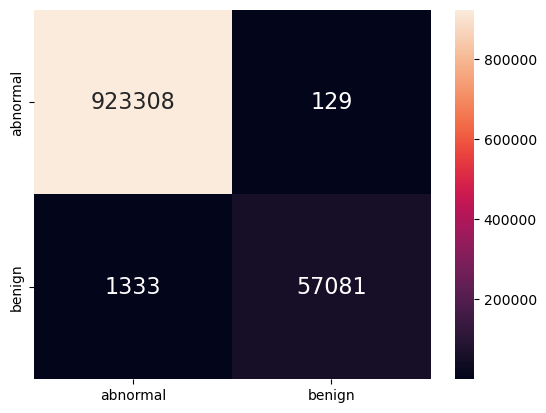

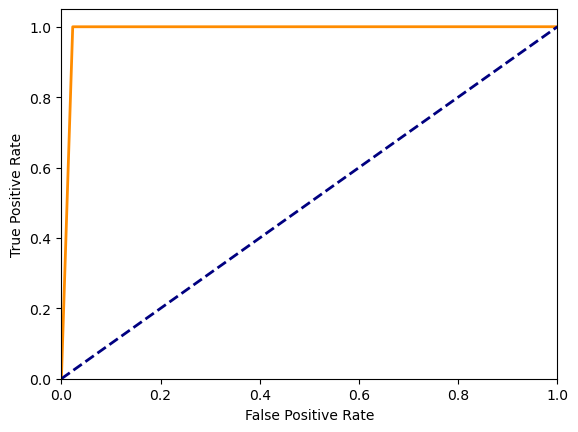

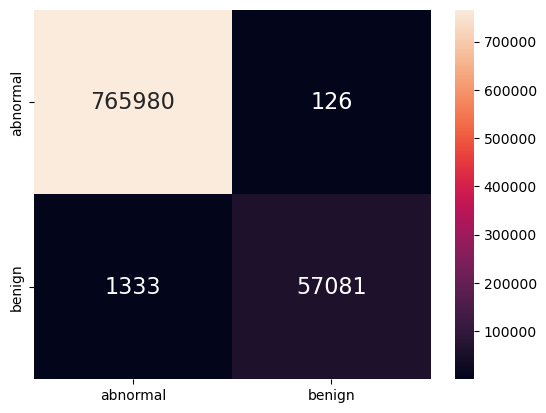

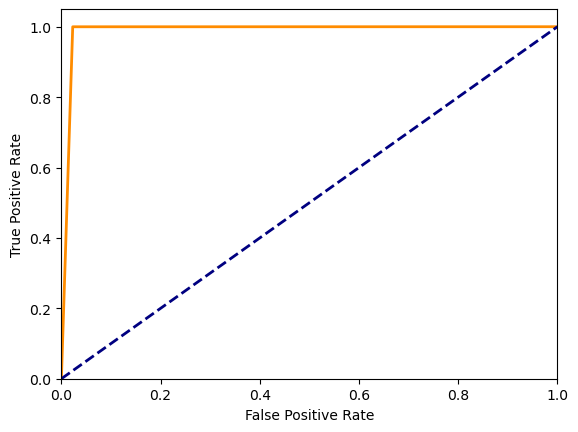

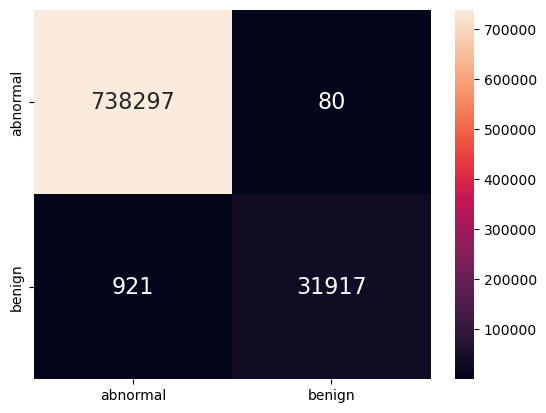

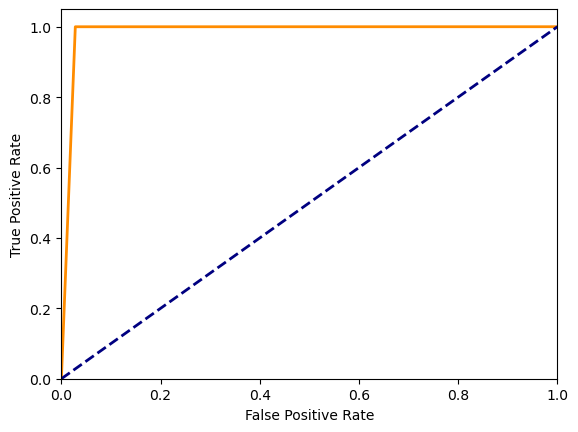

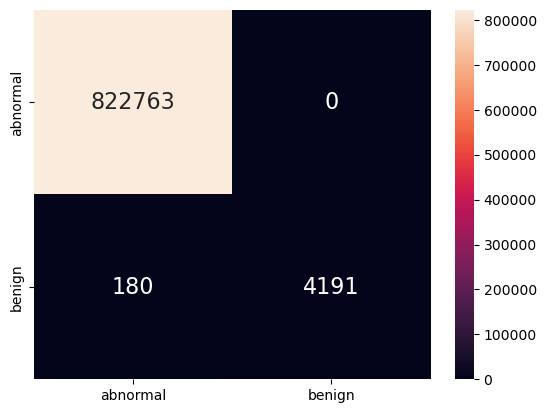

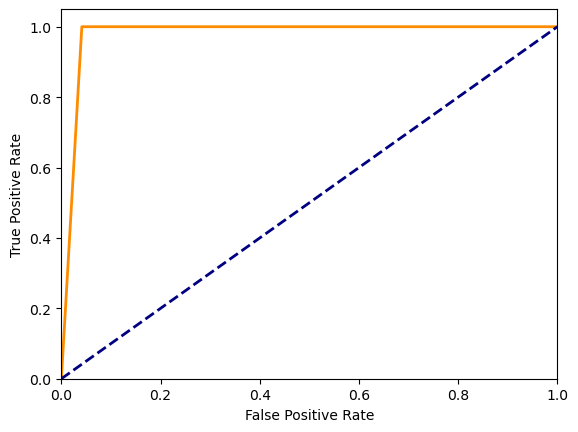

In [41]:
# use global model & device's TR
print("D1: ")
get_mix_result(global_model, tr_1, mix_data_1, mix_label_1)
print('\nD4: ')
get_mix_result(global_model, tr_4, mix_data_4, mix_label_4)
print('\nD5: ')
get_mix_result(global_model, tr_5, mix_data_5, mix_label_5)
print('\nD6: ')
get_mix_result(global_model, tr_6, mix_data_6, mix_label_6)
print('\nD7: ')
get_mix_result(global_model, tr_7, mix_data_7, mix_label_7)


     

In [43]:
import time

start_time = time.time()
# code to load and preprocess your data
# code to train your model
end_time = time.time()

training_time = end_time - start_time
print("Training time:", training_time)


Training time: 3.981590270996094e-05
